<a href="https://colab.research.google.com/github/Alx-a-cod/MLiterallyConfused/blob/main/ML_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ==== STANDARD IMPORTS FOR ML PROJECT ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, accuracy_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import warnings

**=== Fashion-MNIST (Classification, CNN) ===**

`Characteristics`

* Shape: 60,000 train images (28×28 grayscale) + 10,000 test
* No missing values (images are complete)
* Pixel values: 0–255 (uint8)

No missing values, no outliers ---> (images are bounded [0,1]).  

`Dimensionality`

* Original: 784
* Target for PCA/Autoencoder: d = 50 or d = 100

In [3]:
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
import numpy as np

# ==== Load ====
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# ==== Split train into train + val (85/15 from 60k) ====
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.15,
    stratify=y_train_full,
    random_state=42
)

# ==== Flatten and normalize to [0, 1] ====
X_train = X_train.reshape(-1, 784).astype('float32') / 255.0
X_val = X_val.reshape(-1, 784).astype('float32') / 255.0
X_test = X_test.reshape(-1, 784).astype('float32') / 255.0

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Classes: {np.unique(y_train)}")  # Should be [0, 1, ..., 9]
print(f"Pixel range: [{X_train.min()}, {X_train.max()}]")  # Should be [0.0, 1.0]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: (51000, 784), Val: (9000, 784), Test: (10000, 784)
Classes: [0 1 2 3 4 5 6 7 8 9]
Pixel range: [0.0, 1.0]


PCA - Fashion-MNIST
Train: (51000, 50)
Val: (9000, 50)
Test: (10000, 50)
Total variance explained by 50 PCs: 0.8626 (86.26%)


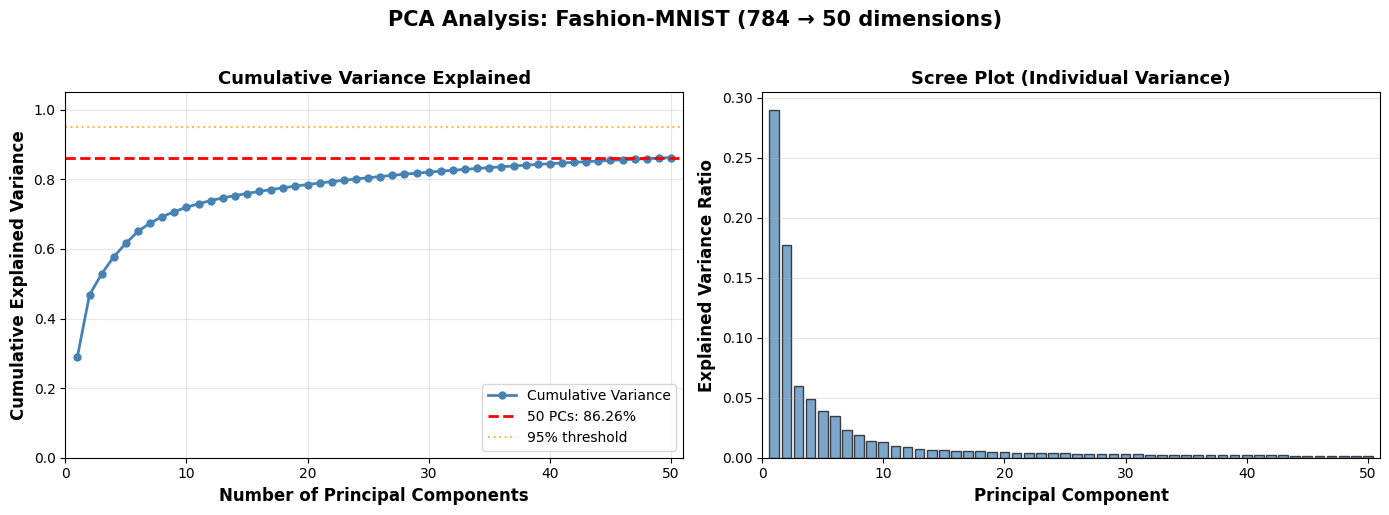

Fashion-MNIST PCA Diagnostics:
Total variance explained by 50 PCs: 0.8626 (86.26%)
Number of PCs needed for 95% variance: 1
Top 5 PC variances: [0.2902 0.1776 0.0602 0.0493 0.0386]


In [4]:
from sklearn.decomposition import PCA
import numpy as np

# ==== PCA: reduce to 50 dimensions ====
pca_fmnist = PCA(n_components=50, random_state=42)

# Fit on training data only
X_train_pca = pca_fmnist.fit_transform(X_train)
X_val_pca = pca_fmnist.transform(X_val)
X_test_pca = pca_fmnist.transform(X_test)

# ==== Verify shapes ====
print(f"PCA - Fashion-MNIST")
print(f"Train: {X_train_pca.shape}")  # (51000, 50)
print(f"Val: {X_val_pca.shape}")      # (9000, 50)
print(f"Test: {X_test_pca.shape}")    # (10000, 50)

# ==== Explained variance ====
explained_var = pca_fmnist.explained_variance_ratio_.sum()
print(f"Total variance explained by 50 PCs: {explained_var:.4f} ({explained_var*100:.2f}%)")

# ==== Cumulative variance plot (for report) ====
import matplotlib.pyplot as plt

# ==== Single detailed plot for Fashion-MNIST ====
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Cumulative explained variance
cumsum_fmnist = np.cumsum(pca_fmnist.explained_variance_ratio_)
axes[0].plot(range(1, 51), cumsum_fmnist, marker='o', markersize=5,
             linewidth=2, color='steelblue', label='Cumulative Variance')
axes[0].axhline(y=0.8626, color='red', linestyle='--', linewidth=2,
                label=f'50 PCs: 86.26%')
axes[0].axhline(y=0.95, color='orange', linestyle=':', linewidth=1.5,
                alpha=0.7, label='95% threshold')
axes[0].set_xlabel('Number of Principal Components', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cumulative Explained Variance', fontsize=12, fontweight='bold')
axes[0].set_title('Cumulative Variance Explained', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10, loc='lower right')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, 51)
axes[0].set_ylim(0, 1.05)

# Right: Individual variance per component (scree plot)
axes[1].bar(range(1, 51), pca_fmnist.explained_variance_ratio_,
            color='steelblue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Principal Component', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Explained Variance Ratio', fontsize=12, fontweight='bold')
axes[1].set_title('Scree Plot (Individual Variance)', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xlim(0, 51)

plt.suptitle('PCA Analysis: Fashion-MNIST (784 → 50 dimensions)',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('pca_fmnist_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

# Print diagnostic info
print("Fashion-MNIST PCA Diagnostics:")
print(f"Total variance explained by 50 PCs: {cumsum_fmnist[-1]:.4f} ({cumsum_fmnist[-1]*100:.2f}%)")
print(f"Number of PCs needed for 95% variance: {np.argmax(cumsum_fmnist >= 0.95) + 1}")
print(f"Top 5 PC variances: {pca_fmnist.explained_variance_ratio_[:5].round(4)}")

FASHION-MNIST AUTOENCODER (784 → 50)


Model: "autoencoder_fmnist"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_2 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Dense)               │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481,346 (1.84 MB)

 Trainable params: 481,346 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0736 - mse: 0.0736 - val_loss: 0.0245 - val_mse: 0.0245
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0224 - mse: 0.0224 - val_loss: 0.0194 - val_mse: 0.0194
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0192 - mse: 0.0192 - val_loss: 0.0173 - val_mse: 0.0173
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0169 - mse: 0.0169 - val_loss: 0.0163 - val_mse: 0.0163
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0149 - val_mse: 0.0149
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0148 - mse: 0.0148 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0138 - val_mse: 0.0138
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0137 - val_mse: 0.0137
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 

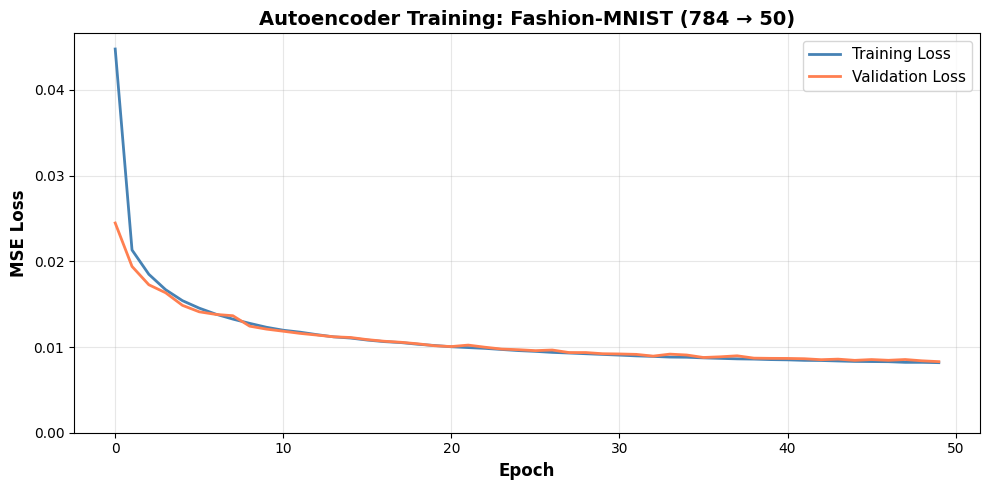


Reconstruction MSE (test set): 0.008433


In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

# ==== Architecture ====
input_dim = 784
encoding_dim = 50

# Input layer
input_layer = Input(shape=(input_dim,), name='input')

# Encoder
encoded = Dense(256, activation='relu', name='encoder_1')(input_layer)
encoded = Dense(128, activation='relu', name='encoder_2')(encoded)
encoded = Dense(encoding_dim, activation='relu', name='bottleneck')(encoded)

# Decoder
decoded = Dense(128, activation='relu', name='decoder_1')(encoded)
decoded = Dense(256, activation='relu', name='decoder_2')(decoded)
decoded = Dense(input_dim, activation='sigmoid', name='output')(decoded)  # sigmoid for [0,1] range

# Models
autoencoder_fmnist = Model(inputs=input_layer, outputs=decoded, name='autoencoder_fmnist')
encoder_fmnist = Model(inputs=input_layer, outputs=encoded, name='encoder_fmnist')

# Compile
autoencoder_fmnist.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])

print("="*80)
print("FASHION-MNIST AUTOENCODER (784 → 50)")
print("="*80)
print(autoencoder_fmnist.summary())

# ==== Training ====
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history_fmnist = autoencoder_fmnist.fit(
    X_train, X_train,  # Input = Output (reconstruction task)
    epochs=50,
    batch_size=256,
    validation_data=(X_val, X_val),
    callbacks=[early_stop],
    verbose=1
)

# ==== Transform data using encoder ====
X_train_ae_fmnist = encoder_fmnist.predict(X_train, verbose=0)
X_val_ae_fmnist = encoder_fmnist.predict(X_val, verbose=0)
X_test_ae_fmnist = encoder_fmnist.predict(X_test, verbose=0)

print("\n" + "="*80)
print("FASHION-MNIST AUTOENCODER RESULTS")
print("="*80)
print(f"Train shape: {X_train_ae_fmnist.shape}")  # (51000, 50)
print(f"Val shape: {X_val_ae_fmnist.shape}")      # (9000, 50)
print(f"Test shape: {X_test_ae_fmnist.shape}")    # (10000, 50)
print(f"Final training loss: {history_fmnist.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history_fmnist.history['val_loss'][-1]:.6f}")

# ==== Visualization: Training curves ====
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(history_fmnist.history['loss'], linewidth=2, label='Training Loss', color='steelblue')
ax.plot(history_fmnist.history['val_loss'], linewidth=2, label='Validation Loss', color='coral')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('MSE Loss', fontsize=12, fontweight='bold')
ax.set_title('Autoencoder Training: Fashion-MNIST (784 → 50)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('autoencoder_training_fmnist.png', dpi=300, bbox_inches='tight')
plt.show()

# ==== Reconstruction quality ====
X_test_reconstructed = autoencoder_fmnist.predict(X_test, verbose=0)
reconstruction_mse = np.mean((X_test - X_test_reconstructed)**2)
print(f"\nReconstruction MSE (test set): {reconstruction_mse:.6f}")


FASHION-MNIST: PCA vs Autoencoder Reconstruction
PCA reconstruction MSE: 0.011989
Autoencoder reconstruction MSE: 0.008160
Improvement: 31.94%


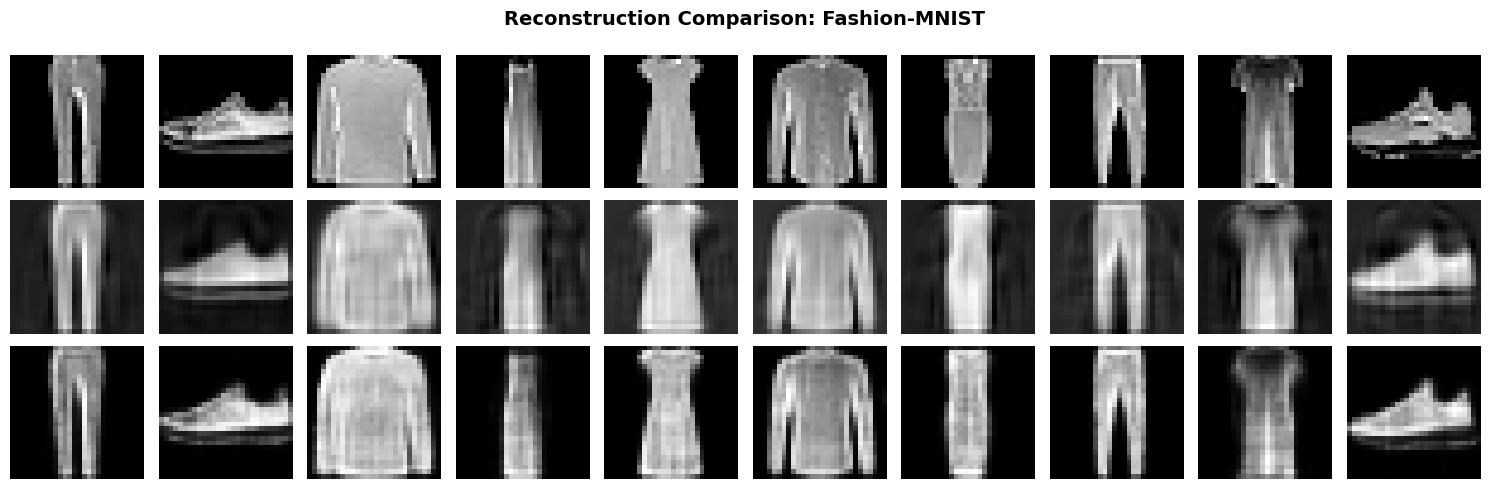

In [13]:
# ==== Fashion-MNIST: PCA vs Autoencoder Reconstruction comparison ====
X_test_reconstructed_pca = pca_fmnist.inverse_transform(X_test_pca)
X_test_reconstructed_ae = autoencoder_fmnist.predict(X_test, verbose=0)

mse_pca = np.mean((X_test - X_test_reconstructed_pca)**2)
mse_ae = np.mean((X_test - X_test_reconstructed_ae)**2)

print("\n" + "="*80)
print("FASHION-MNIST: PCA vs Autoencoder Reconstruction")
print("="*80)
print(f"PCA reconstruction MSE: {mse_pca:.6f}")
print(f"Autoencoder reconstruction MSE: {mse_ae:.6f}")
print(f"Improvement: {((mse_pca - mse_ae) / mse_pca * 100):.2f}%")

# ==== Visual comparison: 10 samples ====
n_samples = 10
indices = np.random.choice(X_test.shape[0], n_samples, replace=False)

X_original = X_test[indices]
X_pca_recon = pca_fmnist.inverse_transform(X_test_pca[indices])
X_ae_recon = autoencoder_fmnist.predict(X_test[indices], verbose=0)

fig, axes = plt.subplots(3, n_samples, figsize=(15, 5))

for i in range(n_samples):
    # Original
    axes[0, i].imshow(X_original[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('Original', fontsize=11, fontweight='bold')

    # PCA reconstruction
    axes[1, i].imshow(X_pca_recon[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('PCA (50d)', fontsize=11, fontweight='bold')

    # Autoencoder reconstruction
    axes[2, i].imshow(X_ae_recon[i].reshape(28, 28), cmap='gray')
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_ylabel('Autoencoder (50d)', fontsize=11, fontweight='bold')

plt.suptitle('Reconstruction Comparison: Fashion-MNIST', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('reconstruction_comparison_fmnist.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_auc_score
import pandas as pd

# ==== Verify data shapes ====
print("="*80)
print("DATA VERIFICATION")
print("="*80)
print(f"Original data:")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"  X_test: {X_test.shape}, y_test: {y_test.shape}")

print(f"\nPCA-reduced data:")
print(f"  X_train_pca: {X_train_pca.shape}")
print(f"  X_val_pca: {X_val_pca.shape}")
print(f"  X_test_pca: {X_test_pca.shape}")

print(f"\nAutoencoder-reduced data:")
print(f"  X_train_ae_fmnist: {X_train_ae_fmnist.shape}")
print(f"  X_val_ae_fmnist: {X_val_ae_fmnist.shape}")
print(f"  X_test_ae_fmnist: {X_test_ae_fmnist.shape}")

print(f"\nLabel distribution (train): {np.bincount(y_train)}")
print(f"Number of classes: {len(np.unique(y_train))}")

DATA VERIFICATION
Original data:
  X_train: (51000, 784), y_train: (51000,)
  X_val: (9000, 784), y_val: (9000,)
  X_test: (10000, 784), y_test: (10000,)

PCA-reduced data:
  X_train_pca: (51000, 50)
  X_val_pca: (9000, 50)
  X_test_pca: (10000, 50)

Autoencoder-reduced data:
  X_train_ae_fmnist: (51000, 50)
  X_val_ae_fmnist: (9000, 50)
  X_test_ae_fmnist: (10000, 50)

Label distribution (train): [5100 5100 5100 5100 5100 5100 5100 5100 5100 5100]
Number of classes: 10


CNN Architecture Design
Architecture Principles
For Original Data (784D):

Reshape to 28×28 for convolutional layers
Standard CNN: Conv2D → MaxPooling → Conv2D → MaxPooling → Flatten → Dense

For Reduced Data (50D - PCA/Autoencoder):

- Cannot use Conv2D directly (50D is not spatial)
- Use Dense layers only (Fully Connected Network, not true CNN)
> Alternative: Reshape 50D → pseudo-image (e.g., 7×7 with padding, but this is artificial)

Assignment interpretation issue: The assignment says "CNN for classification", but CNNs require spatial structure (2D images). For PCA/Autoencoder-reduced data (1D vectors), we must use either:

- Dense-only network (not a true CNN)
- Reshape to pseudo-spatial (e.g., 50D → 7×7 + 1 padding, but this is meaningless)

Recommended approach:

- Use true CNN for original 784D (reshape to 28×28)
- Use Dense network (MLP-style) for 50D reduced data
- Justify in report: "Reduced data loses spatial structure, requiring dense layers"

In [ ]:
# ==== Reshape to 28x28 for Conv2D ====
X_train_original_cnn = X_train.reshape(-1, 28, 28, 1)
X_val_original_cnn = X_val.reshape(-1, 28, 28, 1)
X_test_original_cnn = X_test.reshape(-1, 28, 28, 1)

print(f"Reshaped for CNN: {X_train_original_cnn.shape}")

# ==== CNN Architecture ====
def build_cnn_original():
    model = models.Sequential([
        # Conv Block 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), name='conv1'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), name='pool1'),
        layers.Dropout(0.25),

        # Conv Block 2
        layers.Conv2D(64, (3, 3), activation='relu', name='conv2'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), name='pool2'),
        layers.Dropout(0.25),

        # Flatten and Dense
        layers.Flatten(),
        layers.Dense(128, activation='relu', name='fc1'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax', name='output')
    ], name='CNN_Original')

    return model

model_original = build_cnn_original()
model_original.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("="*80)
print("MODEL 1: CNN ON ORIGINAL DATA (28×28)")
print("="*80)
model_original.summary()

# ==== Training ====
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history_original = model_original.fit(
    X_train_original_cnn, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_val_original_cnn, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ==== Evaluation ====
print("\n" + "="*80)
print("MODEL 1 RESULTS: CNN ON ORIGINAL DATA")
print("="*80)

# Test set predictions
y_pred_original = model_original.predict(X_test_original_cnn, verbose=0).argmax(axis=1)

# Metrics
acc_original = accuracy_score(y_test, y_pred_original)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_original, average='weighted', zero_division=0)

print(f"Test Accuracy: {acc_original:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_original,
                          target_names=['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
                          zero_division=0))

Reshaped for CNN: (51000, 28, 28, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MODEL 1: CNN ON ORIGINAL DATA (28×28)


Model: "CNN_Original"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,930 (882.54 KB)

 Trainable params: 225,482 (880.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 92s 214ms/step - accuracy: 0.7188 - loss: 0.8446 - val_accuracy: 0.5544 - val_loss: 1.2735 - learning_rate: 0.0010
Epoch 2/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 121s 163ms/step - accuracy: 0.8509 - loss: 0.4195 - val_accuracy: 0.8836 - val_loss: 0.3130 - learning_rate: 0.0010
Epoch 3/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 83s 165ms/step - accuracy: 0.8690 - loss: 0.3607 - val_accuracy: 0.8871 - val_loss: 0.3042 - learning_rate: 0.0010
Epoch 4/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 82s 164ms/step - accuracy: 0.8809 - loss: 0.3270 - val_accuracy: 0.9071 - val_loss: 0.2517 - learning_rate: 0.0010
Epoch 5/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 63s 158ms/step - accuracy: 0.8906 - loss: 0.3024 - val_accuracy: 0.8889 - val_loss: 0.2915 - learning_rate: 0.0010
Epoch 6/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 66s 166ms/step - accuracy: 0.8934 - loss: 0.2939 - val_accuracy: 0.9092 - val_loss: 0.2412 - learning_rate: 0.0010
Epoch 7/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 80s 161ms/step - accuracy: 0.

In [8]:
# ==== Dense Network Architecture (no Conv2D, data is 1D) ====
def build_dense_network(input_dim, name='Dense_Network'):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu', name='fc1'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(64, activation='relu', name='fc2'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', name='fc3'),
        layers.Dropout(0.2),
        layers.Dense(10, activation='softmax', name='output')
    ], name=name)

    return model

model_pca = build_dense_network(50, name='Dense_PCA')
model_pca.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n" + "="*80)
print("MODEL 2: DENSE NETWORK ON PCA DATA (50D)")
print("="*80)
model_pca.summary()

# ==== Training ====
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history_pca = model_pca.fit(
    X_train_pca, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_val_pca, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ==== Evaluation ====
print("\n" + "="*80)
print("MODEL 2 RESULTS: DENSE NETWORK ON PCA DATA")
print("="*80)

y_pred_pca = model_pca.predict(X_test_pca, verbose=0).argmax(axis=1)

acc_pca = accuracy_score(y_test, y_pred_pca)
precision_pca, recall_pca, f1_pca, _ = precision_recall_fscore_support(y_test, y_pred_pca, average='weighted', zero_division=0)

print(f"Test Accuracy: {acc_pca:.4f}")
print(f"Precision: {precision_pca:.4f}")
print(f"Recall: {recall_pca:.4f}")
print(f"F1 Score: {f1_pca:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_pca,
                          target_names=['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
                          zero_division=0))


MODEL 2: DENSE NETWORK ON PCA DATA (50D)


Model: "Dense_PCA"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc1 (Dense)                     │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,962 (70.16 KB)

 Trainable params: 17,578 (68.66 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5314 - loss: 1.3954 - val_accuracy: 0.8294 - val_loss: 0.4694 - learning_rate: 0.0010
Epoch 2/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7793 - loss: 0.6194 - val_accuracy: 0.8481 - val_loss: 0.4118 - learning_rate: 0.0010
Epoch 3/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8079 - loss: 0.5463 - val_accuracy: 0.8598 - val_loss: 0.3851 - learning_rate: 0.0010
Epoch 4/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8238 - loss: 0.5044 - val_accuracy: 0.8649 - val_loss: 0.3716 - learning_rate: 0.0010
Epoch 5/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8314 - loss: 0.4784 - val_accuracy: 0.8709 - val_loss: 0.3576 - learning_rate: 0.0010
Epoch 6/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8377 - loss: 0.4623 - val_accuracy: 0.8729 - val_loss: 0.3532 - learning_rate: 0.0010
Epoch 7/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8426 - loss: 0.4475 - 

In [9]:
model_ae = build_dense_network(50, name='Dense_Autoencoder')
model_ae.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n" + "="*80)
print("MODEL 3: DENSE NETWORK ON AUTOENCODER DATA (50D)")
print("="*80)
model_ae.summary()

# ==== Training ====
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history_ae = model_ae.fit(
    X_train_ae_fmnist, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_val_ae_fmnist, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ==== Evaluation ====
print("\n" + "="*80)
print("MODEL 3 RESULTS: DENSE NETWORK ON AUTOENCODER DATA")
print("="*80)

y_pred_ae = model_ae.predict(X_test_ae_fmnist, verbose=0).argmax(axis=1)

acc_ae = accuracy_score(y_test, y_pred_ae)
precision_ae, recall_ae, f1_ae, _ = precision_recall_fscore_support(y_test, y_pred_ae, average='weighted', zero_division=0)

print(f"Test Accuracy: {acc_ae:.4f}")
print(f"Precision: {precision_ae:.4f}")
print(f"Recall: {recall_ae:.4f}")
print(f"F1 Score: {f1_ae:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_ae,
                          target_names=['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
                          zero_division=0))


MODEL 3: DENSE NETWORK ON AUTOENCODER DATA (50D)


Model: "Dense_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc1 (Dense)                     │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,962 (70.16 KB)

 Trainable params: 17,578 (68.66 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.5005 - loss: 1.4194 - val_accuracy: 0.8083 - val_loss: 0.5152 - learning_rate: 0.0010
Epoch 2/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7591 - loss: 0.6622 - val_accuracy: 0.8393 - val_loss: 0.4394 - learning_rate: 0.0010
Epoch 3/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7876 - loss: 0.5918 - val_accuracy: 0.8456 - val_loss: 0.4206 - learning_rate: 0.0010
Epoch 4/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8025 - loss: 0.5524 - val_accuracy: 0.8481 - val_loss: 0.4084 - learning_rate: 0.0010
Epoch 5/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8106 - loss: 0.5281 - val_accuracy: 0.8504 - val_loss: 0.4069 - learning_rate: 0.0010
Epoch 6/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8141 - loss: 0.5163 - val_accuracy: 0.8462 - val_loss: 0.4177 - learning_rate: 0.0010
Epoch 7/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8175 - loss: 0.5079 

In [ ]:
# ==== Summary Table ====
results_df = pd.DataFrame({
    'Model': ['CNN (Original 784D)', 'Dense (PCA 50D)', 'Dense (Autoencoder 50D)'],
    'Accuracy': [acc_original, acc_pca, acc_ae],
    'Precision': [precision, precision_pca, precision_ae],
    'Recall': [recall, recall_pca, recall_ae],
    'F1 Score': [f1, f1_pca, f1_ae],
    'Input Dim': [784, 50, 50],
    'Parameters': [model_original.count_params(), model_pca.count_params(), model_ae.count_params()]
})

print("\n" + "="*80)
print("COMPARATIVE RESULTS: FASHION-MNIST CLASSIFICATION")
print("="*80)
print(results_df.to_string(index=False))
print("\n" + "="*80)

# ==== Visualization: Accuracy Comparison ====
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(results_df['Model']))
width = 0.2

bars1 = ax.bar(x - width, results_df['Accuracy'], width, label='Accuracy', color='steelblue')
bars2 = ax.bar(x, results_df['Precision'], width, label='Precision', color='coral')
bars3 = ax.bar(x + width, results_df['F1 Score'], width, label='F1 Score', color='forestgreen')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Fashion-MNIST Classification: Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'], rotation=15, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.0)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('fmnist_classification_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ==== Plot training history for all three models ====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Model 1: Original
axes[0].plot(history_original.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history_original.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=11, fontweight='bold')
axes[0].set_title('CNN on Original Data (784D)', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Model 2: PCA
axes[1].plot(history_pca.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history_pca.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=11, fontweight='bold')
axes[1].set_title('Dense Network on PCA (50D)', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Model 3: Autoencoder
axes[2].plot(history_ae.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[2].plot(history_ae.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Accuracy', fontsize=11, fontweight='bold')
axes[2].set_title('Dense Network on Autoencoder (50D)', fontsize=12, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.suptitle('Learning Curves: Fashion-MNIST Classification', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fmnist_learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Model 1
cm1 = confusion_matrix(y_test, y_pred_original)
disp1 = ConfusionMatrixDisplay(cm1, display_labels=class_names)
disp1.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('CNN Original (784D)', fontsize=12, fontweight='bold')
axes[0].set_xticklabels(class_names, rotation=45, ha='right', fontsize=8)
axes[0].set_yticklabels(class_names, fontsize=8)

# Model 2
cm2 = confusion_matrix(y_test, y_pred_pca)
disp2 = ConfusionMatrixDisplay(cm2, display_labels=class_names)
disp2.plot(ax=axes[1], cmap='Oranges', colorbar=False)
axes[1].set_title('Dense PCA (50D)', fontsize=12, fontweight='bold')
axes[1].set_xticklabels(class_names, rotation=45, ha='right', fontsize=8)
axes[1].set_yticklabels(class_names, fontsize=8)

# Model 3
cm3 = confusion_matrix(y_test, y_pred_ae)
disp3 = ConfusionMatrixDisplay(cm3, display_labels=class_names)
disp3.plot(ax=axes[2], cmap='Greens', colorbar=False)
axes[2].set_title('Dense Autoencoder (50D)', fontsize=12, fontweight='bold')
axes[2].set_xticklabels(class_names, rotation=45, ha='right', fontsize=8)
axes[2].set_yticklabels(class_names, fontsize=8)

plt.suptitle('Confusion Matrices: Fashion-MNIST Classification', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fmnist_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

**=== California Housing (Regression, FNN) ===**

`Characteristics`

* Shape: 20,640 samples × 8 features
* No missing values (clean dataset)
* Features: MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude
* Target: Continuous (median house value)

No missing values. Outliers exist but are real (e.g., expensive areas, high population density). To be kept.

Dimensionality:

* Original: 8
* Target for PCA/Autoencoder: d = 4 or d = 5

In [21]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# ==== Load ====
data = fetch_california_housing()
X, y = data.data, data.target

# ==== Split: 70% train, 15% val, 15% test ====
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

# ==== Check for missing values ====
print(f"Missing values in train: {np.isnan(X_train).sum()}")  # Should be 0

# ==== Outlier detection (optional, for reporting) ====
from scipy import stats
z_scores = np.abs(stats.zscore(X_train))
outliers = (z_scores > 3).any(axis=1)
print(f"Outlier rows (|z|>3): {outliers.sum()} / {X_train.shape[0]} ({100*outliers.mean():.2f}%)")

# Decision: Keep outliers (real data, small %), but report in analysis

# ==== Standardization ====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# ==== Verify scaling ====
print(f"Train mean: {X_train_scaled.mean(axis=0).round(3)}")  # ~0
print(f"Train std: {X_train_scaled.std(axis=0).round(3)}")    # ~1

print(f"Train: {X_train_scaled.shape}, Val: {X_val_scaled.shape}, Test: {X_test_scaled.shape}")

Missing values in train: 0
Outlier rows (|z|>3): 591 / 14448 (4.09%)
Train mean: [-0. -0.  0. -0.  0. -0.  0. -0.]
Train std: [1. 1. 1. 1. 1. 1. 1. 1.]
Train: (14448, 8), Val: (3096, 8), Test: (3096, 8)



PCA - California Housing
Train: (14448, 5)
Val: (3096, 5)
Test: (3096, 5)
Total variance explained by 5 PCs: 0.9018 (90.18%)

PCA Components (loadings):
     MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
PC1   0.085    -0.016     0.458      0.415      -0.161    -0.009     0.559   
PC2   0.217    -0.259     0.530      0.491       0.094    -0.002    -0.395   
PC3   0.229    -0.622    -0.063     -0.193       0.656     0.172     0.177   
PC4   0.878     0.147     0.059     -0.323      -0.282     0.112    -0.068   
PC5  -0.111     0.228     0.026      0.098       0.047     0.960    -0.019   

     Longitude  
PC1     -0.523  
PC2      0.446  
PC3     -0.167  
PC4     -0.055  
PC5      0.024  


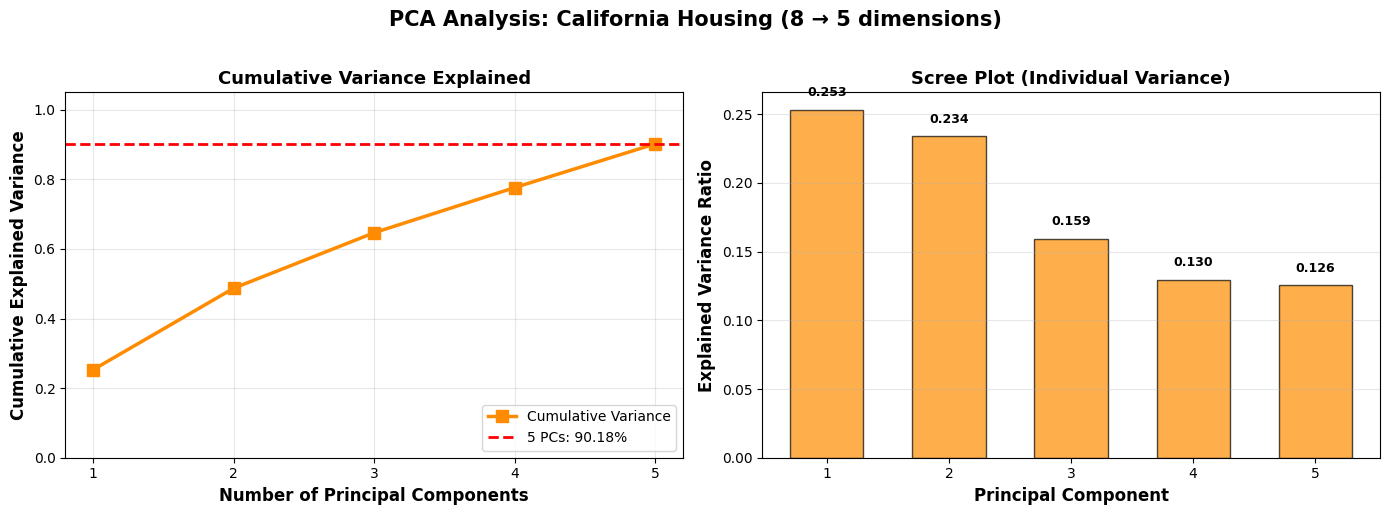


California Housing PCA Diagnostics:
Total variance explained by 5 PCs: 0.9018 (90.18%)
Individual PC variances: [0.2533 0.2339 0.1594 0.1296 0.1255]


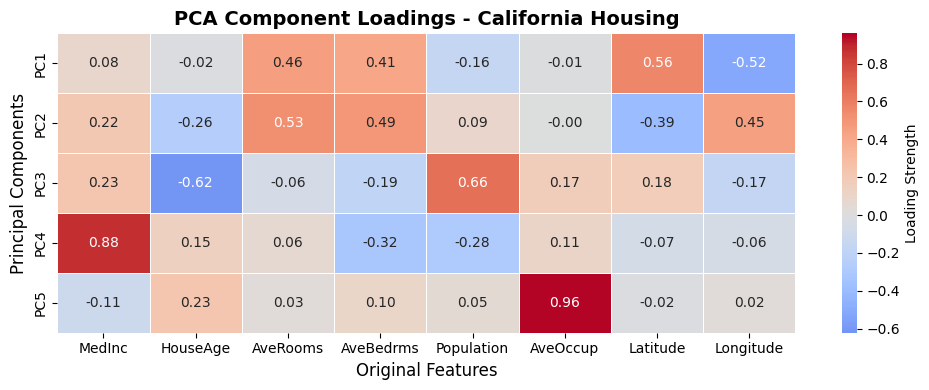

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# ==== PCA: reduce to 5 dimensions ====
pca_housing = PCA(n_components=5, random_state=42)

X_train_housing_pca = pca_housing.fit_transform(X_train_scaled)
X_val_housing_pca = pca_housing.transform(X_val_scaled)
X_test_housing_pca = pca_housing.transform(X_test_scaled)

# ==== Verify shapes ====
print(f"\nPCA - California Housing")
print(f"Train: {X_train_housing_pca.shape}")  # (14448, 5)
print(f"Val: {X_val_housing_pca.shape}")      # (3096, 5)
print(f"Test: {X_test_housing_pca.shape}")    # (3096, 5)

# ==== Explained variance ====
explained_var = pca_housing.explained_variance_ratio_.sum()
print(f"Total variance explained by 5 PCs: {explained_var:.4f} ({explained_var*100:.2f}%)")

# ==== Component interpretation (for report) ====
components_df = pd.DataFrame(
    pca_housing.components_,
    columns=['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'],
    index=[f'PC{i+1}' for i in range(5)]
)
print("\nPCA Components (loadings):")
print(components_df.round(3))

# ==== Single detailed plot for California Housing ====
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Cumulative explained variance
cumsum_housing = np.cumsum(pca_housing.explained_variance_ratio_)
axes[0].plot(range(1, 6), cumsum_housing, marker='s', markersize=8,
             linewidth=2.5, color='darkorange', label='Cumulative Variance')
axes[0].axhline(y=0.9018, color='red', linestyle='--', linewidth=2,
                label=f'5 PCs: 90.18%')
axes[0].set_xlabel('Number of Principal Components', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cumulative Explained Variance', fontsize=12, fontweight='bold')
axes[0].set_title('Cumulative Variance Explained', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10, loc='lower right')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(1, 6))
axes[0].set_ylim(0, 1.05)

# Right: Individual variance per component
axes[1].bar(range(1, 6), pca_housing.explained_variance_ratio_,
            color='darkorange', edgecolor='black', alpha=0.7, width=0.6)
axes[1].set_xlabel('Principal Component', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Explained Variance Ratio', fontsize=12, fontweight='bold')
axes[1].set_title('Scree Plot (Individual Variance)', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticks(range(1, 6))

# Add value labels on bars
for i, v in enumerate(pca_housing.explained_variance_ratio_):
    axes[1].text(i+1, v + 0.01, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')

plt.suptitle('PCA Analysis: California Housing (8 → 5 dimensions)',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('pca_housing_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCalifornia Housing PCA Diagnostics:")
print(f"Total variance explained by 5 PCs: {cumsum_housing[-1]:.4f} ({cumsum_housing[-1]*100:.2f}%)")
print(f"Individual PC variances: {pca_housing.explained_variance_ratio_.round(4)}")

import seaborn as sns

# ==== PCA component loadings heatmap ====
components_df = pd.DataFrame(
    pca_housing.components_,
    columns=['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'],
    index=[f'PC{i+1}' for i in range(5)]
)

plt.figure(figsize=(10, 4))
sns.heatmap(components_df, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            cbar_kws={'label': 'Loading Strength'}, linewidths=0.5)
plt.title('PCA Component Loadings - California Housing', fontsize=14, fontweight='bold')
plt.xlabel('Original Features', fontsize=12)
plt.ylabel('Principal Components', fontsize=12)
plt.tight_layout()
plt.savefig('pca_loadings_housing.png', dpi=300, bbox_inches='tight')
plt.show()


CALIFORNIA HOUSING AUTOENCODER (8 → 5)


Model: "autoencoder_housing"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 6)              │            54 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 5)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Dense)               │ (None, 6)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 8)              │            56 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181 (724.00 B)

 Trainable params: 181 (724.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.7853 - mse: 0.7853 - val_loss: 0.5788 - val_mse: 0.5788
Epoch 2/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.5687 - mse: 0.5687 - val_loss: 0.4625 - val_mse: 0.4625
Epoch 3/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.4963 - mse: 0.4963 - val_loss: 0.3529 - val_mse: 0.3529
Epoch 4/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.4154 - mse: 0.4154 - val_loss: 0.2370 - val_mse: 0.2370
Epoch 5/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.3348 - mse: 0.3348 - val_loss: 0.1974 - val_mse: 0.1974
Epoch 6/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3058 - mse: 0.3058 - val_loss: 0.1763 - val_mse: 0.1763
Epoch 7/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3605 - mse: 0.3605 - val_loss: 0.1548 - val_mse: 0.1548
Epoch 8/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2111 - mse: 0.2111 - val_loss: 0.1371 - val_mse: 0.1371
Epoch 9/100
226/226 ━━━━━━━━━━━━━━━━━━━━

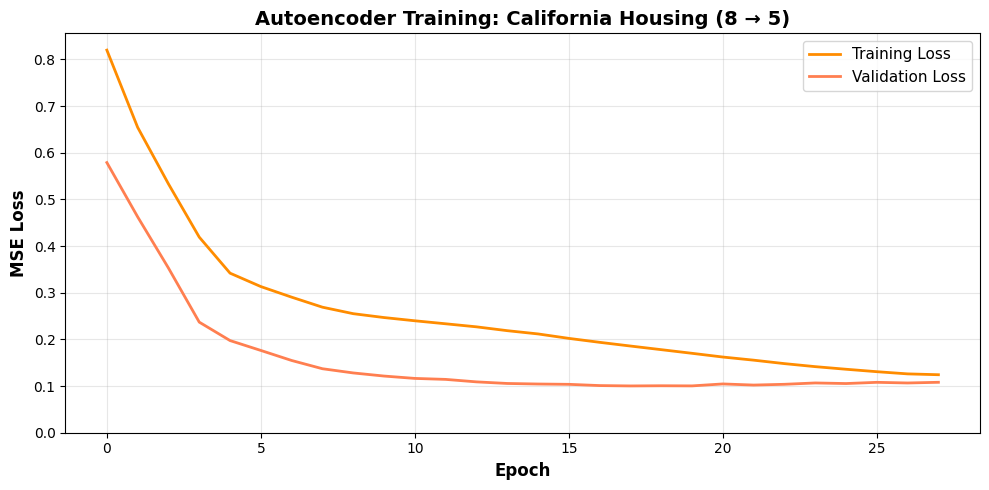


Reconstruction MSE (test set): 0.111888


In [23]:
# ==== Architecture ====
input_dim = 8
encoding_dim = 5

# Input layer
input_layer = Input(shape=(input_dim,), name='input')

# Encoder (shallow network for small input)
encoded = Dense(6, activation='relu', name='encoder_1')(input_layer)
encoded = Dense(encoding_dim, activation='relu', name='bottleneck')(encoded)

# Decoder
decoded = Dense(6, activation='relu', name='decoder_1')(encoded)
decoded = Dense(input_dim, activation='linear', name='output')(decoded)  # linear for continuous data

# Models
autoencoder_housing = Model(inputs=input_layer, outputs=decoded, name='autoencoder_housing')
encoder_housing = Model(inputs=input_layer, outputs=encoded, name='encoder_housing')

# Compile
autoencoder_housing.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])

print("\n" + "="*80)
print("CALIFORNIA HOUSING AUTOENCODER (8 → 5)")
print("="*80)
print(autoencoder_housing.summary())

# ==== Training ====
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history_housing = autoencoder_housing.fit(
    X_train_scaled, X_train_scaled,
    epochs=100,
    batch_size=64,
    validation_data=(X_val_scaled, X_val_scaled),
    callbacks=[early_stop],
    verbose=1
)

# ==== Transform data ====
X_train_ae_housing = encoder_housing.predict(X_train_scaled, verbose=0)
X_val_ae_housing = encoder_housing.predict(X_val_scaled, verbose=0)
X_test_ae_housing = encoder_housing.predict(X_test_scaled, verbose=0)

print("\n" + "="*80)
print("CALIFORNIA HOUSING AUTOENCODER RESULTS")
print("="*80)
print(f"Train shape: {X_train_ae_housing.shape}")  # (14448, 5)
print(f"Val shape: {X_val_ae_housing.shape}")      # (3096, 5)
print(f"Test shape: {X_test_ae_housing.shape}")    # (3096, 5)
print(f"Final training loss: {history_housing.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history_housing.history['val_loss'][-1]:.6f}")

# ==== Visualization: Training curves ====
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(history_housing.history['loss'], linewidth=2, label='Training Loss', color='darkorange')
ax.plot(history_housing.history['val_loss'], linewidth=2, label='Validation Loss', color='coral')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('MSE Loss', fontsize=12, fontweight='bold')
ax.set_title('Autoencoder Training: California Housing (8 → 5)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('autoencoder_training_housing.png', dpi=300, bbox_inches='tight')
plt.show()

# ==== Reconstruction quality ====
X_test_reconstructed = autoencoder_housing.predict(X_test_scaled, verbose=0)
reconstruction_mse = np.mean((X_test_scaled - X_test_reconstructed)**2)
print(f"\nReconstruction MSE (test set): {reconstruction_mse:.6f}")

In [24]:
X_test_reconstructed_pca_housing = pca_housing.inverse_transform(X_test_housing_pca)
X_test_reconstructed_ae_housing = autoencoder_housing.predict(X_test_scaled, verbose=0)

mse_pca_housing = np.mean((X_test_scaled - X_test_reconstructed_pca_housing)**2)
mse_ae_housing = np.mean((X_test_scaled - X_test_reconstructed_ae_housing)**2)

print("\n" + "="*80)
print("CALIFORNIA HOUSING: PCA vs Autoencoder Reconstruction")
print("="*80)
print(f"PCA reconstruction MSE: {mse_pca_housing:.6f}")
print(f"Autoencoder reconstruction MSE: {mse_ae_housing:.6f}")
print(f"Improvement: {((mse_pca_housing - mse_ae_housing) / mse_pca_housing * 100):.2f}%")


CALIFORNIA HOUSING: PCA vs Autoencoder Reconstruction
PCA reconstruction MSE: 0.093712
Autoencoder reconstruction MSE: 0.111888
Improvement: -19.40%


**=== Credit Card (Clustering, K-Means) ===**  

`Characteristics`

* Source: https://www.kaggle.com/datasets/arjunbhasin2013/ccdata
* Shape: 8,950 samples × 18 columns (17 features + 1 ID)
* Features: BALANCE, PURCHASES, CASH_ADVANCE, CREDIT_LIMIT, PAYMENTS, etc.
* Missing values: ~300 missing in CREDIT_LIMIT, MINIMUM_PAYMENTS

Missing values handled by median imputation. Outliers kept (informative for segmentation).

`Dimensionality`

* Original: 17
* Target for PCA/Autoencoder: d = 8 or d = 10

In [25]:
import kagglehub
import pandas as pd
import os

# ==== Download dataset ====
path = kagglehub.dataset_download("arjunbhasin2013/ccdata")
print("Path to dataset files:", path)

# ==== List files in downloaded directory ====
files = os.listdir(path)
print(f"Files in dataset: {files}")

# ==== Load CSV (filename is 'CC GENERAL.csv' with a SPACE) ====
csv_path = os.path.join(path, 'CC GENERAL.csv')
df = pd.read_csv(csv_path)

print(f"\nDataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Using Colab cache for faster access to the 'ccdata' dataset.
Path to dataset files: /kaggle/input/ccdata
Files in dataset: ['CC GENERAL.csv']

Dataset loaded successfully!
Shape: (8950, 18)
Columns: ['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']


In [26]:
import kagglehub
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import stats

# ==== Download dataset ====
path = kagglehub.dataset_download("arjunbhasin2013/ccdata")
csv_path = os.path.join(path, 'CC GENERAL.csv')
df = pd.read_csv(csv_path)

print(f"Shape: {df.shape}")
print(f"Missing values:\n{df.isna().sum()}\n")

# ==== Drop ID column ====
X = df.drop(columns=['CUST_ID']).values

# ==== Handle missing values ====
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

print(f"Missing values after imputation: {np.isnan(X_imputed).sum()}")

# ==== Outlier detection (for reporting) ====
z_scores = np.abs(stats.zscore(X_imputed))
outliers = (z_scores > 3).any(axis=1)
print(f"Outlier rows (|z|>3): {outliers.sum()} / {X_imputed.shape[0]} ({100*outliers.mean():.2f}%)")

# ==== Standardization ====
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# ==== Verify scaling ====
print(f"Mean after scaling: {X_scaled.mean(axis=0).round(3)}")  # Should be ~0
print(f"Std after scaling: {X_scaled.std(axis=0).round(3)}")    # Should be ~1

# ==== Optional: Split for evaluation ====
X_train, X_test = train_test_split(X_scaled, test_size=0.20, random_state=42)

print(f"\nFull scaled data: {X_scaled.shape}")
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Using Colab cache for faster access to the 'ccdata' dataset.
Shape: (8950, 18)
Missing values:
CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Missing values after imputation: 0
Outlier rows (|z|>3): 1516 / 8950 (16.94%)
Mean after scaling: [-0.  0.  0. -0.  0. -0.  0.  0.  0. -0. -0. -0.  0. -0.  0. -0.  0.]
Std


PCA - Credit Card
Train: (7160, 8)
Test: (1790, 8)
Total variance explained by 8 PCs: 0.8534 (85.34%)


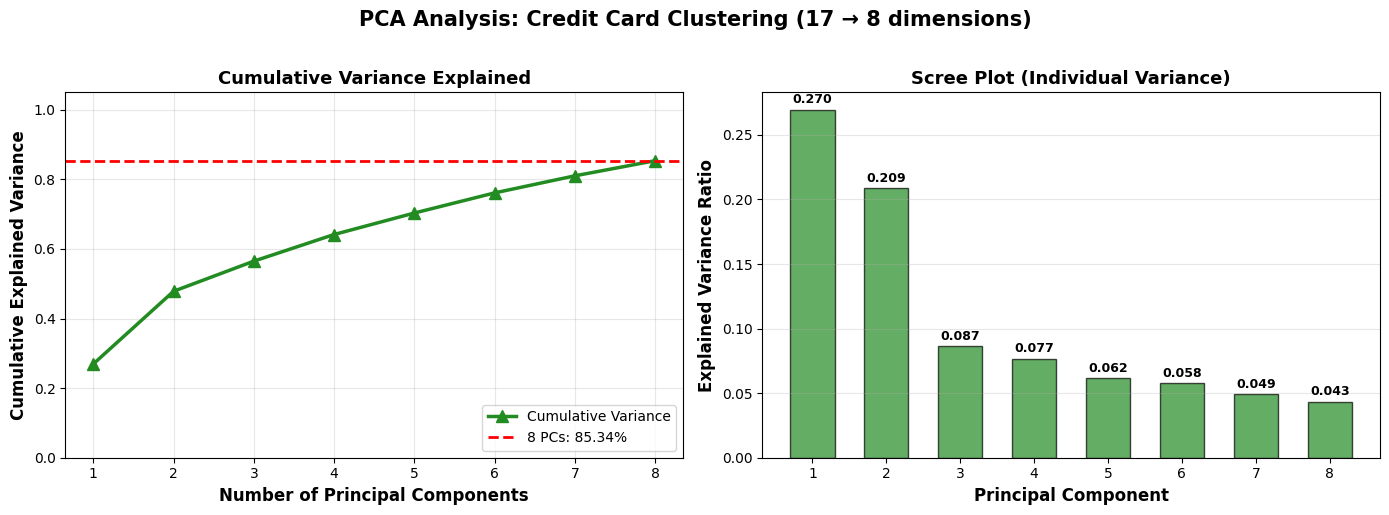


Credit Card PCA Diagnostics:
Total variance explained by 8 PCs: 0.8534 (85.34%)
Individual PC variances: [0.2695 0.2088 0.0865 0.0765 0.0617 0.0578 0.0491 0.0434]


In [27]:
# ==== PCA: reduce to 8 dimensions ====
pca_credit = PCA(n_components=8, random_state=42)

X_train_credit_pca = pca_credit.fit_transform(X_train)
X_test_credit_pca = pca_credit.transform(X_test)

# ==== Verify shapes ====
print(f"\nPCA - Credit Card")
print(f"Train: {X_train_credit_pca.shape}")  # (7160, 8)
print(f"Test: {X_test_credit_pca.shape}")    # (1790, 8)

# ==== Explained variance ====
explained_var = pca_credit.explained_variance_ratio_.sum()
print(f"Total variance explained by 8 PCs: {explained_var:.4f} ({explained_var*100:.2f}%)")

# ==== Single detailed plot for Credit Card ====
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Cumulative explained variance
cumsum_credit = np.cumsum(pca_credit.explained_variance_ratio_)
axes[0].plot(range(1, 9), cumsum_credit, marker='^', markersize=8,
             linewidth=2.5, color='forestgreen', label='Cumulative Variance')
axes[0].axhline(y=0.8534, color='red', linestyle='--', linewidth=2,
                label=f'8 PCs: 85.34%')
axes[0].set_xlabel('Number of Principal Components', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cumulative Explained Variance', fontsize=12, fontweight='bold')
axes[0].set_title('Cumulative Variance Explained', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10, loc='lower right')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(1, 9))
axes[0].set_ylim(0, 1.05)

# Right: Individual variance per component
axes[1].bar(range(1, 9), pca_credit.explained_variance_ratio_,
            color='forestgreen', edgecolor='black', alpha=0.7, width=0.6)
axes[1].set_xlabel('Principal Component', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Explained Variance Ratio', fontsize=12, fontweight='bold')
axes[1].set_title('Scree Plot (Individual Variance)', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticks(range(1, 9))

# Add value labels on bars
for i, v in enumerate(pca_credit.explained_variance_ratio_):
    axes[1].text(i+1, v + 0.005, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')

plt.suptitle('PCA Analysis: Credit Card Clustering (17 → 8 dimensions)',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('pca_credit_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCredit Card PCA Diagnostics:")
print(f"Total variance explained by 8 PCs: {cumsum_credit[-1]:.4f} ({cumsum_credit[-1]*100:.2f}%)")
print(f"Individual PC variances: {pca_credit.explained_variance_ratio_.round(4)}")


CREDIT CARD AUTOENCODER (17 → 8)


Model: "autoencoder_credit"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 12)             │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 8)              │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Dense)               │ (None, 12)             │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 17)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 649 (2.54 KB)

 Trainable params: 649 (2.54 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.0621 - mse: 1.0621 - val_loss: 0.9583 - val_mse: 0.9583
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8829 - mse: 0.8829 - val_loss: 0.8384 - val_mse: 0.8384
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7824 - mse: 0.7824 - val_loss: 0.7347 - val_mse: 0.7347
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6767 - mse: 0.6767 - val_loss: 0.6096 - val_mse: 0.6096
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5739 - mse: 0.5739 - val_loss: 0.4990 - val_mse: 0.4990
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5183 - mse: 0.5183 - val_loss: 0.4498 - val_mse: 0.4498
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4333 - mse: 0.4333 - val_loss: 0.4172 - val_mse: 0.4172
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4187 - mse: 0.4187 - val_loss: 0.3900 - val_mse: 0.3900
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 

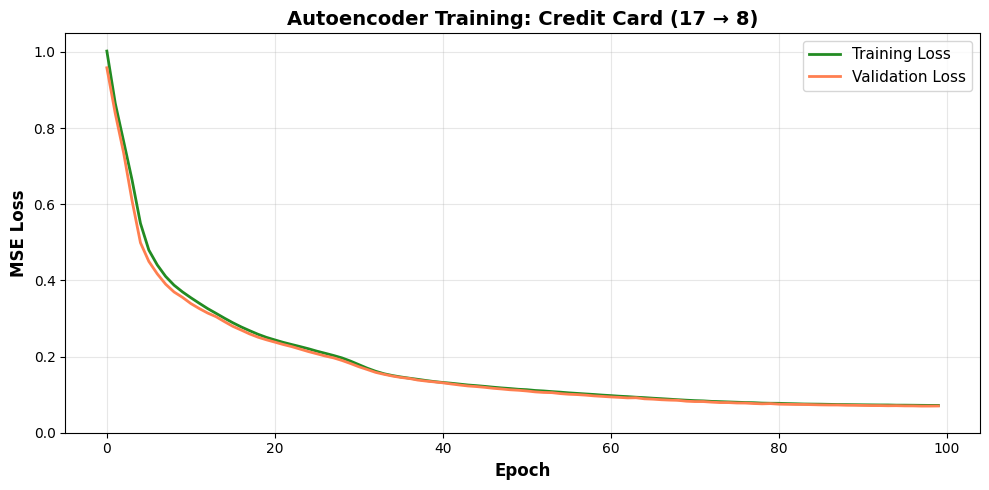


Reconstruction MSE (test set): 0.086749


In [28]:
# ==== Architecture ====
input_dim = 17
encoding_dim = 8

# Input layer
input_layer = Input(shape=(input_dim,), name='input')

# Encoder
encoded = Dense(12, activation='relu', name='encoder_1')(input_layer)
encoded = Dense(encoding_dim, activation='relu', name='bottleneck')(encoded)

# Decoder
decoded = Dense(12, activation='relu', name='decoder_1')(encoded)
decoded = Dense(input_dim, activation='linear', name='output')(decoded)

# Models
autoencoder_credit = Model(inputs=input_layer, outputs=decoded, name='autoencoder_credit')
encoder_credit = Model(inputs=input_layer, outputs=encoded, name='encoder_credit')

# Compile
autoencoder_credit.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])

print("\n" + "="*80)
print("CREDIT CARD AUTOENCODER (17 → 8)")
print("="*80)
print(autoencoder_credit.summary())

# ==== Training ====
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history_credit = autoencoder_credit.fit(
    X_train, X_train,
    epochs=100,
    batch_size=128,
    validation_split=0.15,  # Use 15% of training data as validation
    callbacks=[early_stop],
    verbose=1
)

# ==== Transform data ====
X_train_ae_credit = encoder_credit.predict(X_train, verbose=0)
X_test_ae_credit = encoder_credit.predict(X_test, verbose=0)

print("\n" + "="*80)
print("CREDIT CARD AUTOENCODER RESULTS")
print("="*80)
print(f"Train shape: {X_train_ae_credit.shape}")  # (7160, 8)
print(f"Test shape: {X_test_ae_credit.shape}")    # (1790, 8)
print(f"Final training loss: {history_credit.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history_credit.history['val_loss'][-1]:.6f}")

# ==== Visualization: Training curves ====
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(history_credit.history['loss'], linewidth=2, label='Training Loss', color='forestgreen')
ax.plot(history_credit.history['val_loss'], linewidth=2, label='Validation Loss', color='coral')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('MSE Loss', fontsize=12, fontweight='bold')
ax.set_title('Autoencoder Training: Credit Card (17 → 8)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('autoencoder_training_credit.png', dpi=300, bbox_inches='tight')
plt.show()

# ==== Reconstruction quality ====
X_test_reconstructed = autoencoder_credit.predict(X_test, verbose=0)
reconstruction_mse = np.mean((X_test - X_test_reconstructed)**2)
print(f"\nReconstruction MSE (test set): {reconstruction_mse:.6f}")

In [29]:
X_test_reconstructed_pca_credit = pca_credit.inverse_transform(X_test_credit_pca)
X_test_reconstructed_ae_credit = autoencoder_credit.predict(X_test, verbose=0)

mse_pca_credit = np.mean((X_test - X_test_reconstructed_pca_credit)**2)
mse_ae_credit = np.mean((X_test - X_test_reconstructed_ae_credit)**2)

print("\n" + "="*80)
print("CREDIT CARD: PCA vs Autoencoder Reconstruction")
print("="*80)
print(f"PCA reconstruction MSE: {mse_pca_credit:.6f}")
print(f"Autoencoder reconstruction MSE: {mse_ae_credit:.6f}")
print(f"Improvement: {((mse_pca_credit - mse_ae_credit) / mse_pca_credit * 100):.2f}%")


CREDIT CARD: PCA vs Autoencoder Reconstruction
PCA reconstruction MSE: 0.162593
Autoencoder reconstruction MSE: 0.086749
Improvement: 46.65%
